### Load required libraries and data

In [1]:
import os
import anndata as ad
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import copy
import re
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from datetime import datetime
from igraph import *
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import arviz as az

pwd = os.getcwd()

2022-09-22 09:32:47.582635: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Define analysis functions

In [2]:
def run_scCODA(cell_count, random_effect, split_key, split_value, labels_keys, tests, region, covariates, formula, diagnostic_plots=True, figsize=(20,6)):
    for j in labels_keys:
        print(str(datetime.now()) + " -- Starting labels_keys=" + j)
        cell_count = cell_count.loc[[i in split_value for i in cell_count[split_key]], :]
        counts = sp.sparse.csr_matrix(np.random.poisson(1, size=(cell_count.shape[0], 0)), dtype=np.float32)
        adata = ad.AnnData(counts)
        adata.obs_names = cell_count.index
        adata.obs = cell_count

        abundances = dat.from_scanpy(
            adata,
            cell_type_identifier=j,
            sample_identifier=random_effect,
        )
        tmp = adata.obs.loc[:, covariates]
        tmp.drop_duplicates(inplace=True)
        tmp.index = tmp.library_prep
        tmp.drop([random_effect], axis=1, inplace=True)
        abundances.obs = tmp.loc[abundances.obs.index, :]

        if diagnostic_plots == True:
            tmp = abundances.obs.copy()
            for i in tmp.columns:
                if i.endswith("_codes"):
                    continue
                tmp[i] = tmp[i].astype("category")
                tmp[i + "_codes"] = tmp[i].cat.codes
                tmp.drop(i, axis=1, inplace=True)
            results = np.zeros((tmp.shape[1],tmp.shape[1]))

            for a in range(tmp.shape[1]):
                for b in range(tmp.shape[1]):
                    results[a,b] = sp.stats.spearmanr(tmp.iloc[:,a], tmp.iloc[:,b])[0]

            results = pd.DataFrame(results, columns=tmp.columns, index=tmp.columns)
            sns.heatmap(results);
            plt.show()
            try:
                boxplots(abundances, feature_name="region", figsize=figsize, y_scale="log_relative")
            except:
                boxplots(abundances, feature_name="species", figsize=figsize, y_scale="log_relative")
            boxplots(abundances, feature_name="sex", figsize=figsize, y_scale="log_relative")
            plt.show()

        outfile = " ".join(split_value) + "_" + j + "_results.csv"
              
        for k in tests:
            print(str(datetime.now()) + " -- testing across " + k)
            if (abundances.obs[k].dtype == "object" and len(np.unique(abundances.obs[k])) < 3) or abundances.obs[k].dtype != "object":
                if os.path.exists(os.path.join(pwd, "output", region, k)) is False:
                    os.makedirs(os.path.join(pwd, "output", region, k))
                i = 0
                cell_types = abundances.var.index
                try:
                    del results_table
                except:
                    pass

                while i < cell_types.shape[0]:    

                    ct = cell_types[i]
                    print("Reference: " + ct)

                    pickle_file = os.path.join(pwd, "output", region, k, ct.replace("/", " ") + ".pkl")
                    if os.path.exists(pickle_file):
                        with open(pickle_file, 'rb') as pickle_load:
                            results = pickle.load(pickle_load)

                    else:
                        models = mod.CompositionalAnalysis(abundances, formula=formula + k, reference_cell_type=ct)
                        results = models.sample_hmc()
                        results.save(pickle_file)

                    accepted = results.sample_stats["is_accepted"].to_numpy()

                    if accepted.sum() / accepted.shape[1] < 0.6:
                        del results
                        os.remove(pickle_file)
                        print("Did not achieve acceptance threshold, trying again")
                        continue

                    else:
                        print("Converged!")
                        i = i + 1

                    current_results = results.summary_prepare()[1]
                    current_results = current_results.reset_index()
                    current_results["Reference Cell Type"] = ct

                    try:
                        results_table = pd.concat([results_table, current_results], axis=0)
                    except:
                        results_table = current_results.copy()

                results_table.to_csv(os.path.join(pwd, "output", region, k, outfile))
            else:
                for l in np.unique(abundances.obs[k]):
                    if os.path.exists(os.path.join(pwd, "output", region, k, l)) is False:
                        os.makedirs(os.path.join(pwd, "output", region, k, l))

                    print("Reference " + k + ": " + l)
                    i = 0
                    cell_types = abundances.var.index
                    try:
                        del results_table
                    except:
                        pass

                    while i < cell_types.shape[0]:    

                        ct = cell_types[i]
                        print("Reference cell type: " + ct)

                        pickle_file = os.path.join(pwd, "output", region, k, l, ct.replace("/", " ") + ".pkl")
                        if os.path.exists(pickle_file):
                            with open(pickle_file, 'rb') as pickle_load:
                                results = pickle.load(pickle_load)

                        else:
                            models = mod.CompositionalAnalysis(abundances, formula=formula + "C(" + k + ", Treatment('" + l + "'))", reference_cell_type=ct)
                            results = models.sample_hmc()
                            results.save(pickle_file)

                        accepted = results.sample_stats["is_accepted"].to_numpy()

                        if accepted.sum() / accepted.shape[1] < 0.6:
                            del results
                            os.remove(pickle_file)
                            print("Did not achieve acceptance threshold, trying again")
                            continue

                        else:
                            print("Converged!")
                            i = i + 1

                        current_results = results.summary_prepare()[1]
                        current_results = current_results.reset_index()
                        current_results["Reference Cell Type"] = ct

                        try:
                            results_table = pd.concat([results_table, current_results], axis=0)
                        except:
                            results_table = current_results.copy()

                    results_table.to_csv(os.path.join(pwd, "output", region, k, l, outfile)) 
            
def boxplots(
        data,
        feature_name,
        y_scale="relative",
        plot_facets=False,
        add_dots=False,
        cell_types=None,
        args_boxplot={},
        args_swarmplot={},
        figsize=None,
        dpi=100,
        cmap="Blues",
        plot_legend=True,
        level_order=None):
    """
    Grouped boxplot visualization. The cell counts for each cell type are shown as a group of boxplots,
    with intra--group separation by a covariate from data.obs.
    The cell type groups can either be ordered along the x-axis of a single plot (plot_facets=False) or as plot facets (plot_facets=True).
    Parameters
    ----------
    data
        A scCODA-compatible data object
    feature_name
        The name of the feature in data.obs to plot
    y_scale
        Transformation to of cell counts. Options: "relative" - Relative abundance, "log" - log(count), "count" - absolute abundance (cell counts)
    plot_facets
        If False, plot cell types on the x-axis. If True, plot as facets
    add_dots
        If True, overlay a scatterplot with one dot for each data point
    cell_types
        Subset of cell types that should be plotted
    args_boxplot
        Arguments passed to sns.boxplot
    args_swarmplot
            Arguments passed to sns.swarmplot
    figsize
        figure size
    dpi
        dpi setting
    cmap
        The seaborn color map for the barplot
    plot_legend
        If True, adds a legend
    level_order
        Custom ordering of bars on the x-axis
    Returns
    -------
    Depending on `plot_facets`, returns a :class:`~plt.AxesSubplot` (`plot_facets = False`) or :class:`~sns.axisgrid.FacetGrid` (`plot_facets = True`) object
    ax
        if `plot_facets = False`
    g
        if `plot_facets = True`
    """

    # y scale transformations
    if y_scale == "relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = data.X/sample_sums
        value_name = "Proportion"
    elif y_scale == "log_relative":
        sample_sums = np.sum(data.X, axis=1, keepdims=True)
        X = np.log10((data.X + 1)/(sample_sums + data.shape[1]))
        value_name = "log(Proportion)"
    # add pseudocount 1 if using log scale (needs to be improved)
    elif y_scale == "log":
        X = np.log10(data.X + 1)
        value_name = "log(count)"
    elif y_scale == "count":
        X = data.X
        value_name = "count"
    else:
        raise ValueError("Invalid y_scale transformation")

    count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
        merge(data.obs[feature_name], left_index=True, right_index=True)
    plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)
    if cell_types is not None:
        plot_df = plot_df[plot_df["Cell type"].isin(cell_types)]

    if plot_facets:

        if level_order is None:
            level_order = pd.unique(plot_df[feature_name])

        K = X.shape[1]

        g = sns.FacetGrid(
            plot_df,
            col="Cell type",
            sharey=False,
            col_wrap=np.floor(np.sqrt(K)),
            height=5,
            aspect=2,
        )
        g.map(
            sns.boxplot,
            feature_name,
            value_name,
            palette=cmap,
            order=level_order,
            **args_boxplot
        )

        if add_dots:

            if "hue" in args_swarmplot:
                hue = args_swarmplot.pop("hue")
            else:
                hue = None

            if hue is None:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    color="black",
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")
            else:
                g.map(
                    sns.swarmplot,
                    feature_name,
                    value_name,
                    hue,
                    order=level_order,
                    **args_swarmplot
                ).set_titles("{col_name}")

        return g

    else:

        if level_order:
            args_boxplot["hue_order"] = level_order
            args_swarmplot["hue_order"] = level_order

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.boxplot(x="Cell type", y=value_name, hue=feature_name, data=plot_df, fliersize=1,
                    palette=cmap, ax=ax, **args_boxplot)

        if add_dots:
            sns.swarmplot(
                x="Cell type",
                y=value_name,
                data=plot_df,
                hue=feature_name,
                ax=ax,
                dodge=True,
                color="black",
                **args_swarmplot
            )

        cell_types = pd.unique(plot_df["Cell type"])
        ax.set_xticklabels(cell_types, rotation=90)

        if plot_legend:
            handles, labels = ax.get_legend_handles_labels()
            handout = []
            labelout = []
            for h, l in zip(handles, labels):
                if l not in labelout:
                    labelout.append(l)
                    handout.append(h)
            ax.legend(handout, labelout, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title=feature_name)

        plt.tight_layout()

        return ax

### Cross areal

#### Run scCODA on non-neuronal cells

In [3]:
cell_count = pd.read_csv("meta_10x_2_11_22.csv", index_col="sample_id")
cell_count["library_prep"] = [re.sub("[ATGC]+-[0-9]{0,3}([^-]+)(-[0-9]+)?$", "\\1", i) for i in cell_count.index]
cell_count = cell_count.loc[cell_count["dataset"] != "lein_10x_layer5_only", :].copy()

2022-09-22 10:14:06.229575 -- Starting labels_keys=cross_area_subclass
No covariate information specified!


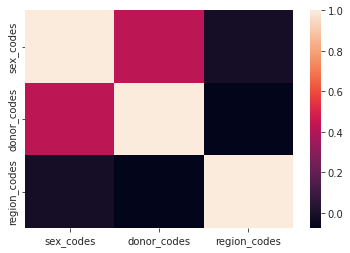

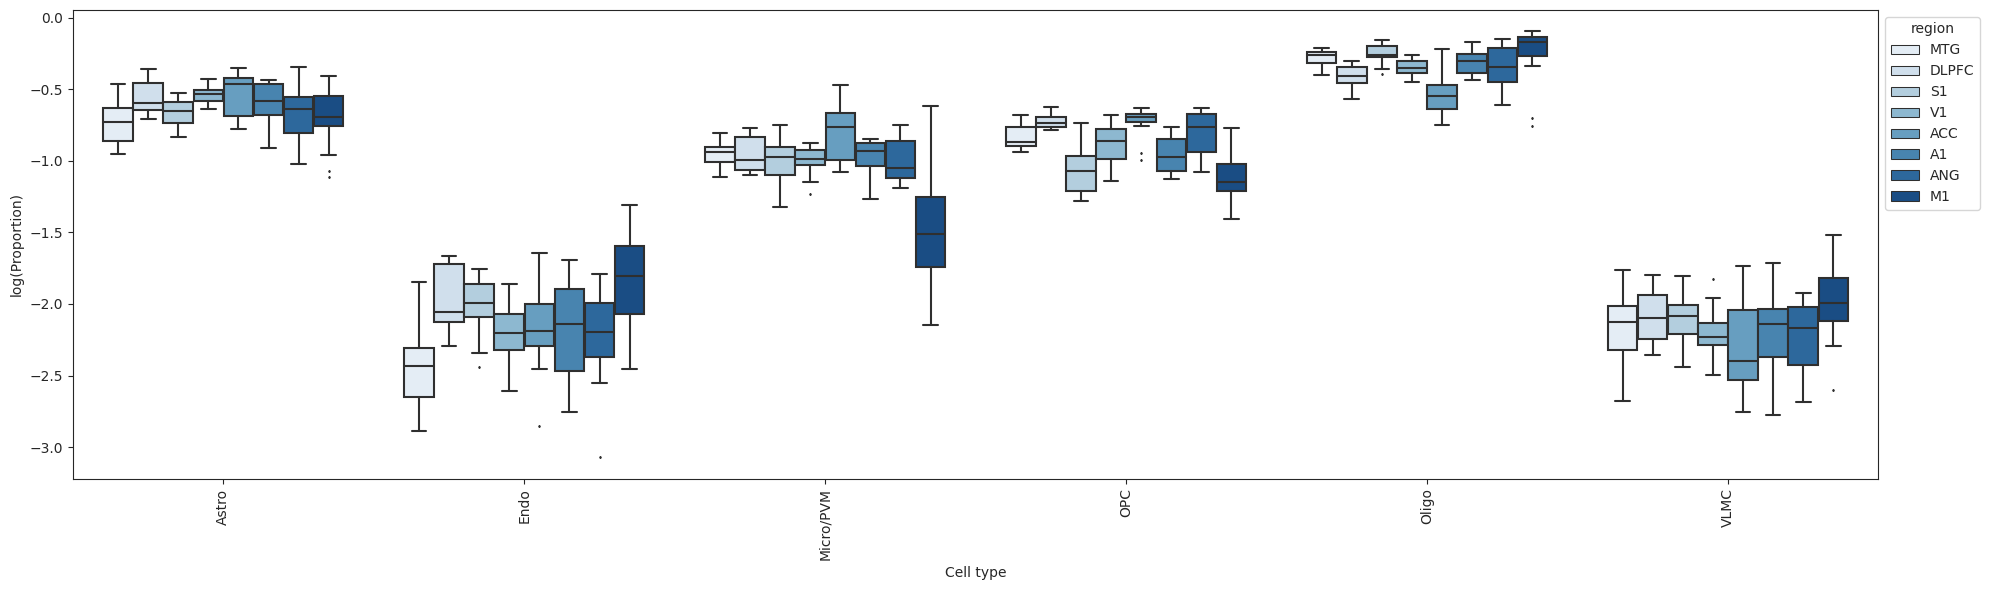

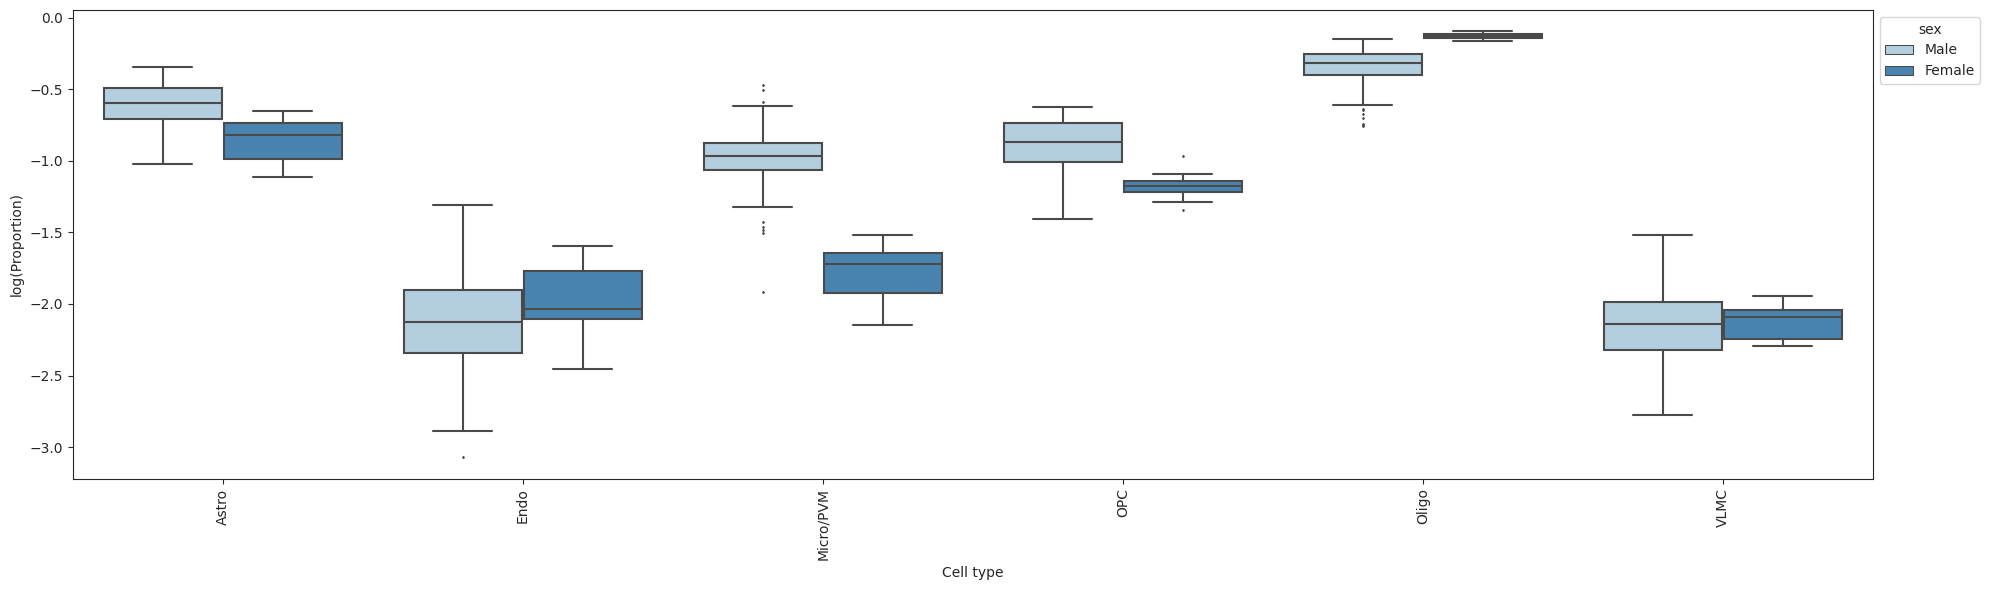

2022-09-22 10:14:07.550131 -- testing across region
Reference region: A1
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!
Reference cell type: VLMC
Converged!
Reference region: ACC
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: ANG
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: DLPFC
Reference cell type: Astro


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: M1
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: MTG
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: S1
Reference cell type: Astro
Converged!
Reference cell type: Endo
Converged!
Reference cell type: Micro/PVM
Converged!
Reference cell type: OPC
Converged!
Reference cell type: Oligo
Converged!
Reference cell type: VLMC
Converged!
Reference region: V1
Reference cell type: Astro
Con

/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!
Reference cell type: VLMC
Converged!
2022-09-22 10:14:59.999019 -- Starting labels_keys=cross_area_cluster
No covariate information specified!


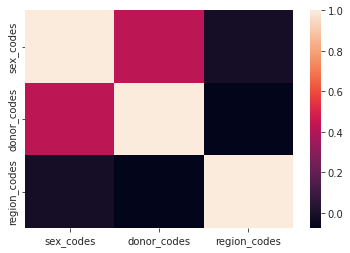

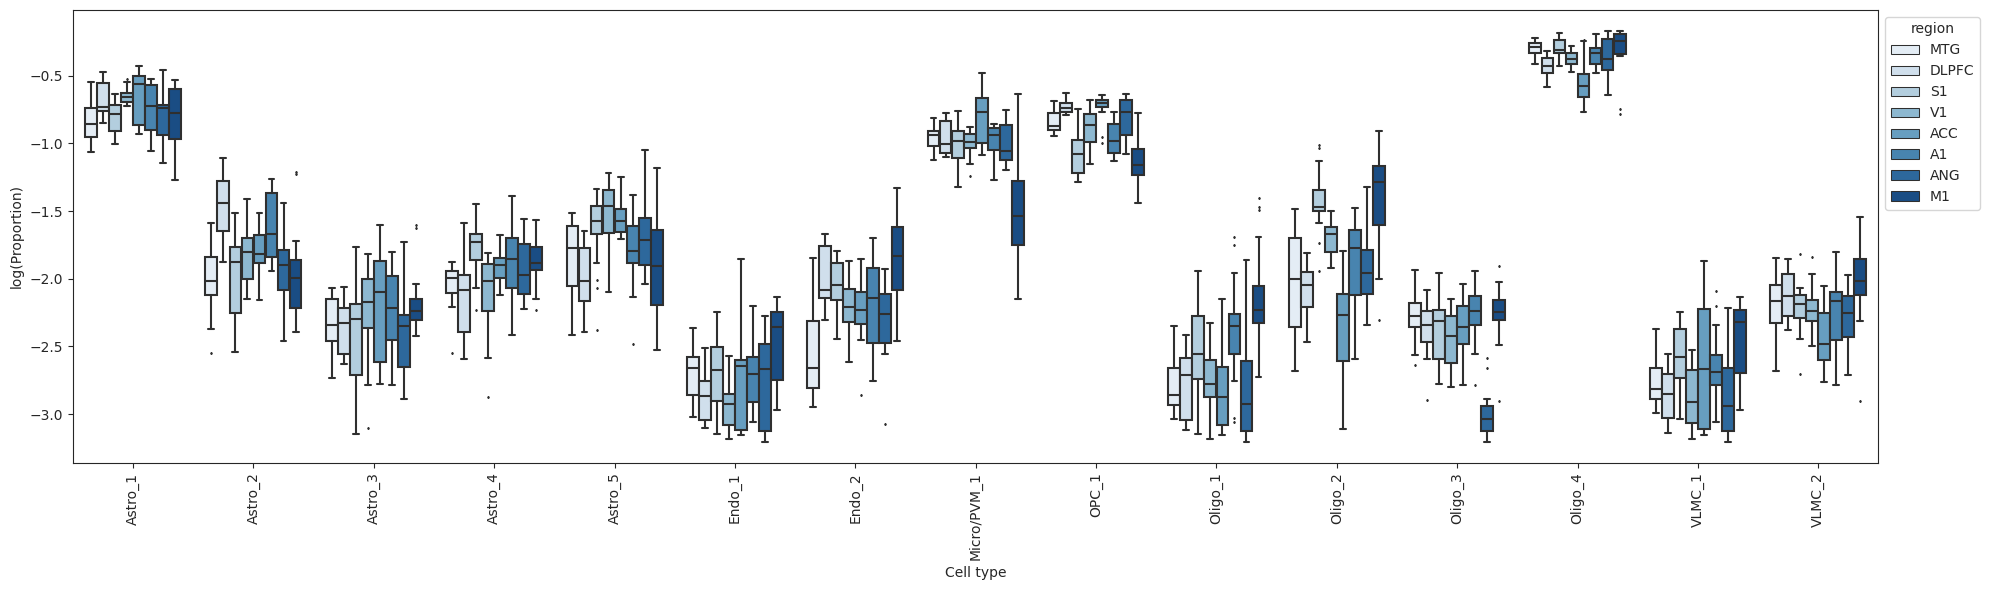

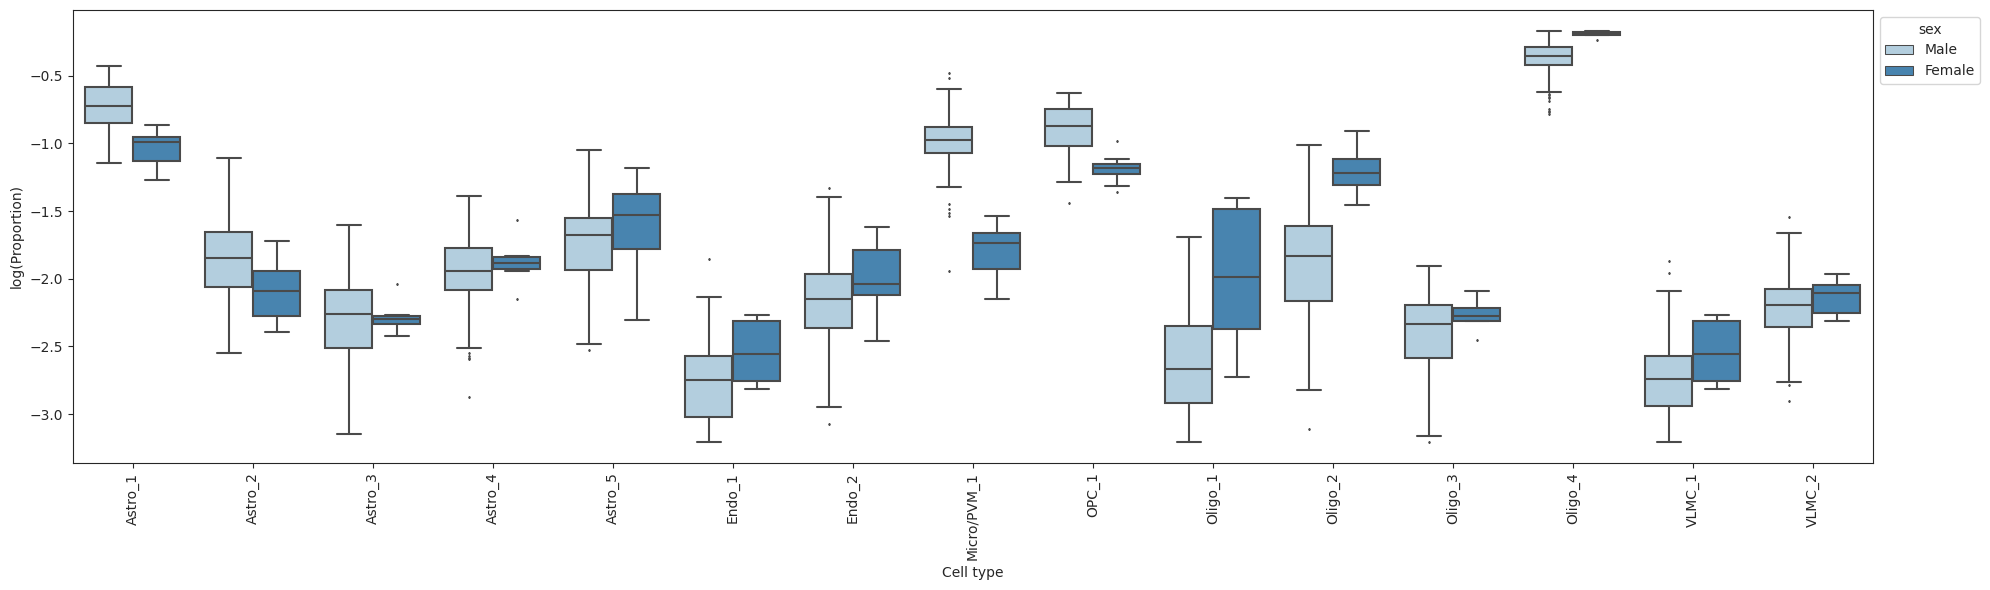

2022-09-22 10:15:02.039762 -- testing across region
Reference region: A1
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!
Reference cell type: OPC_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!
Reference cell type: VLMC_2
Converged!
Reference region: ACC
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: OPC_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: VLMC_1
Converged!
Reference cell type: VLMC_2
Converged!
Reference region: ANG
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!
Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!
Reference cell type: VLMC_2
Converged!
Reference region: DLPFC
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: VLMC_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: M1
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!
Reference cell type: VLMC_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: MTG
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!
Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_2
Converged!
Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: VLMC_2
Converged!
Reference region: S1
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!
Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!
Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: VLMC_1
Converged!
Reference cell type: VLMC_2
Converged!
Reference region: V1
Reference cell type: Astro_1
Converged!
Reference cell type: Astro_2
Converged!
Reference cell type: Astro_3
Converged!
Reference cell type: Astro_4
Converged!
Reference cell type: Astro_5
Converged!
Reference cell type: Endo_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Endo_2
Converged!
Reference cell type: Micro/PVM_1
Converged!
Reference cell type: OPC_1
Converged!
Reference cell type: Oligo_1
Converged!
Reference cell type: Oligo_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Oligo_3
Converged!
Reference cell type: Oligo_4
Converged!
Reference cell type: VLMC_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: VLMC_2
Converged!


In [37]:
region = "cross_areal"
formula = "sex + "
covariates = ["library_prep", "sex", "donor", "region"]
tests = ["region"]
labels_keys=["cross_area_subclass", "cross_area_cluster"]
run_scCODA(
    cell_count=cell_count,
    random_effect="library_prep",
    split_key="class",
    split_value=["non-neuronal"],
    labels_keys=labels_keys,
    region=region,
    covariates=covariates,
    tests=tests,
    formula=formula,
    figsize=(20,6)
)

/scratch/fast/6427930/ipykernel_299333/3189890854.py:32: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
/scratch/fast/6427930/ipykernel_299333/3189890854.py:38: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  results_table["Covariate"].cat.remove_unused_categories(inplace=True)


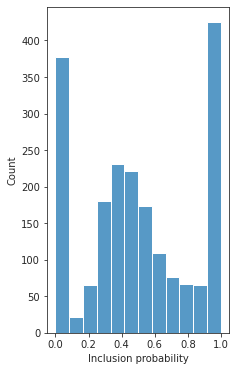

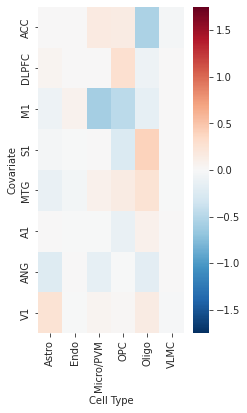

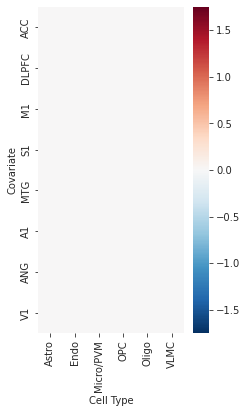

/scratch/fast/6427930/ipykernel_299333/3189890854.py:26: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Cell Type"].cat.reorder_categories(plot_order[k], inplace=True)
/scratch/fast/6427930/ipykernel_299333/3189890854.py:32: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
/scratch/fast/6427930/ipykernel_299333/3189890854.py:38: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  results_table["Covariate"].cat.remove_unused_categories(inplace=True)


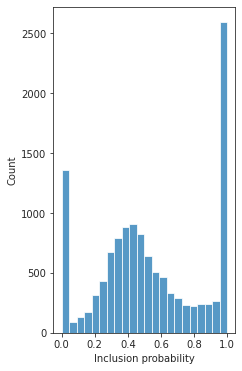

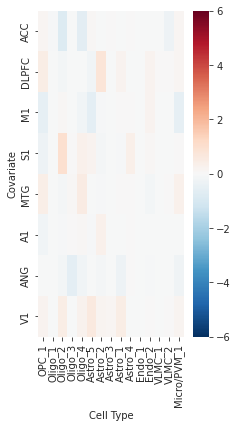

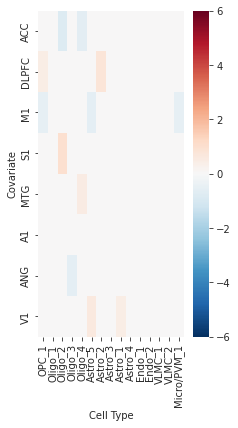

In [64]:
plt.rcParams['figure.figsize'] = (3.26,6)
dend_order = pd.read_csv("dend_order_glia.csv", header=None)
plot_size = {"class": [-1, 1], "cross_area_subclass": [-1.75, 1.75], "cross_area_cluster": [-6, 6]}
plot_order = {"cross_area_cluster": dend_order.iloc[:, 0].to_list()}

plot_colors = {}
covariate_order = ["ACC", "DLPFC", "M1", "S1", "MTG", "A1", "ANG", "V1", "sex[T.Male]"]
drop_covariates = ["sex[T.Male]"]

for j in tests:
    for k in labels_keys:
        results_tables = glob.glob(os.path.join("output", region, j, "**", "non-neuronal_" + k + "_results.csv"))
        results_table = False
        for z in results_tables:
            tmp = pd.read_csv(z, index_col=0)
            tmp["Covariate"] = [re.sub("C\([^,]+, Treatment\('[^\)]+'\)\)\[T.([^\]]+)\]$", "\\1", y) for y in tmp["Covariate"]]
            try:
                results_table = pd.concat([results_table, tmp], axis=0)
            except:
                results_table = tmp.copy()
        
        results_table["Credible"] = results_table["Final Parameter"] != 0
        
        try:
            results_table["Cell Type"] = results_table["Cell Type"].astype("category")
            results_table["Cell Type"].cat.reorder_categories(plot_order[k], inplace=True) 
        except:
            pass
        
        try:
            results_table["Covariate"] = results_table["Covariate"].astype("category")
            results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
        except:
            pass
        
        try:
            results_table = results_table.loc[[l not in drop_covariates for l in results_table["Covariate"]], :]
            results_table["Covariate"].cat.remove_unused_categories(inplace=True)
        except:
            pass
        
        sns.histplot(results_table["Inclusion probability"]);
        plt.show();
        
        tmp = results_table.loc[:, ["Covariate", "Cell Type", "Final Parameter"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.columns = ["Covariate", "Cell Type", "Effect Size"]
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0,
            cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );        plt.savefig(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_unfiltered.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_unfiltered.csv"))
        
        tmp2 = results_table.loc[:, ["Covariate", "Cell Type", "Inclusion probability"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.loc[tmp2["Inclusion probability"] < 0.8, "Effect Size"] = 0
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0, cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );        plt.savefig(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_p_gt_0.8.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "glia_" + j + "_" + k + "_effect_size_p_gt_0.8.csv"))
            
plt.rcParams['figure.figsize'] = (6,4)

#### Run scCODA on neuronal cells

2022-07-13 19:17:24.588118 -- Starting labels_keys=class
No covariate information specified!


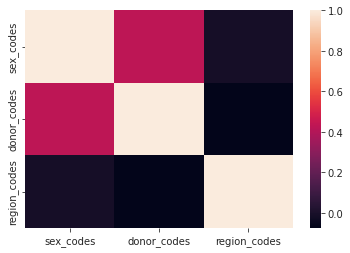

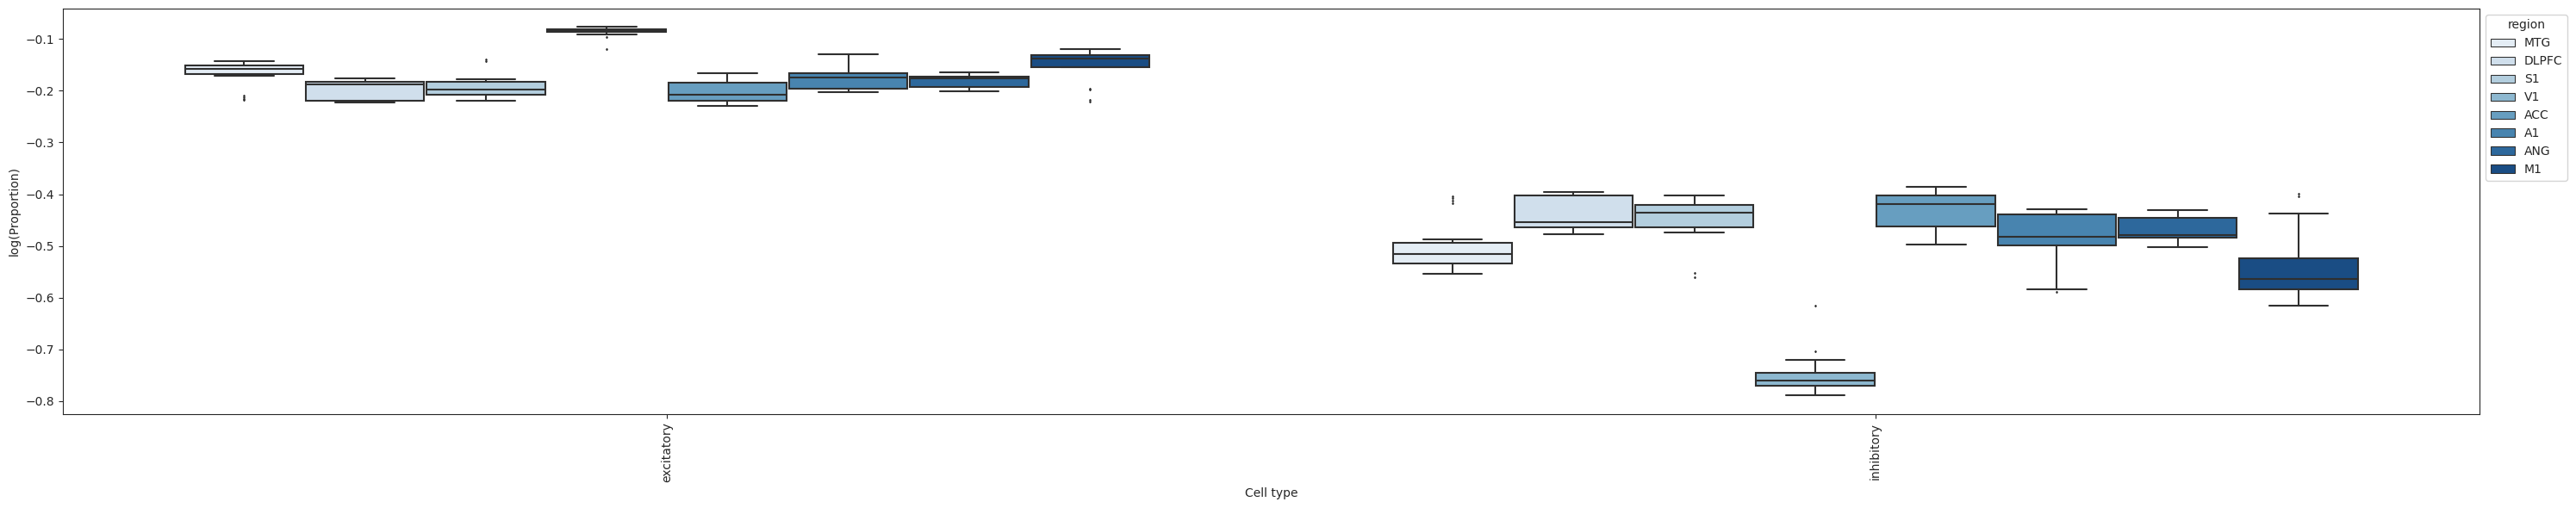

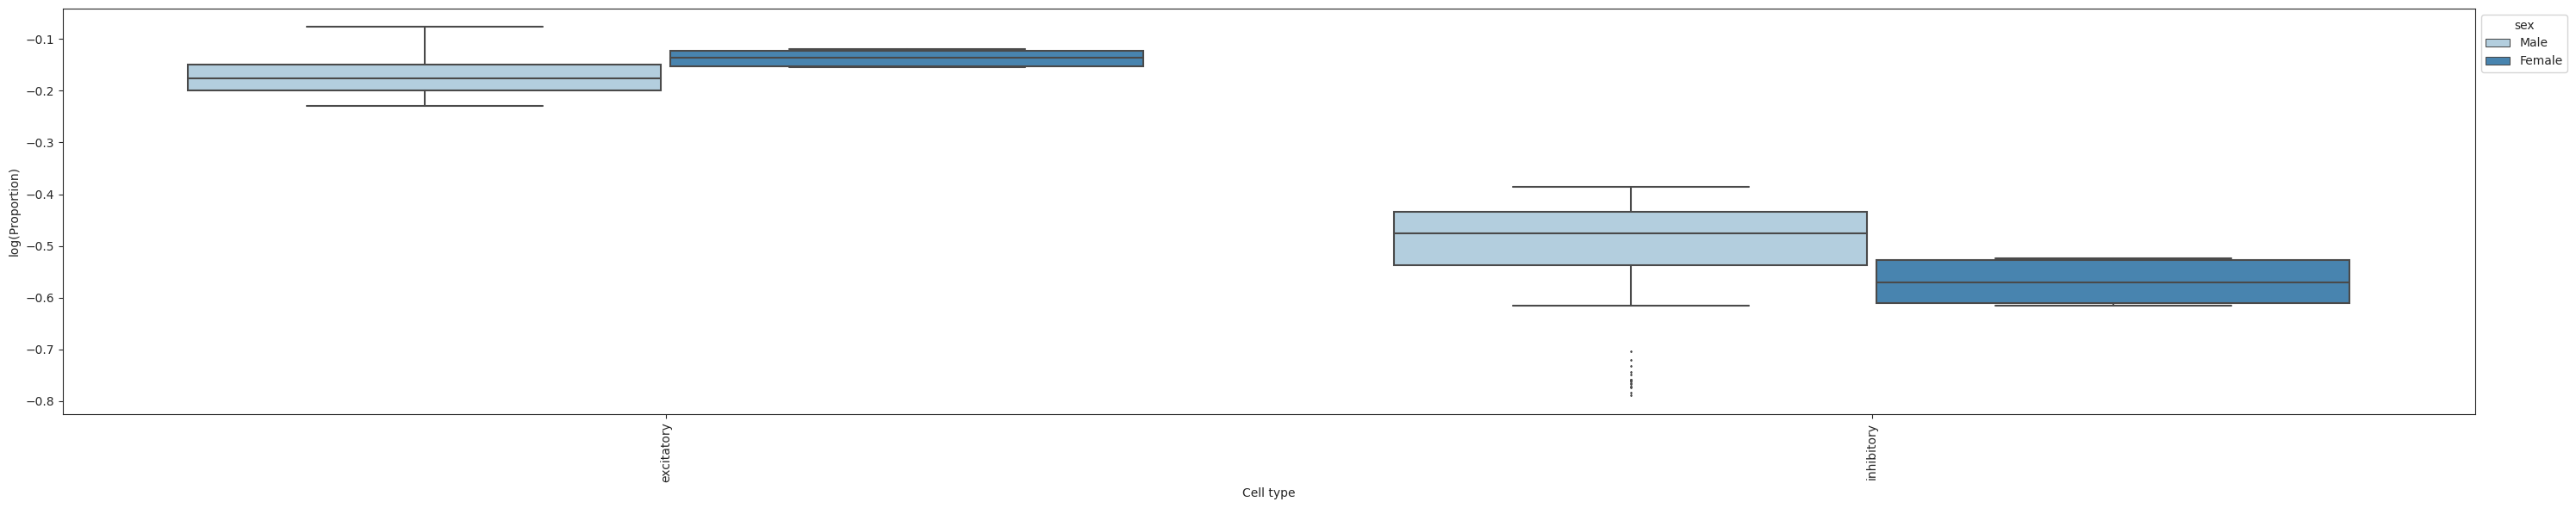

2022-07-13 19:17:26.711176 -- testing across region
Reference region: A1
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: ACC
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: ANG
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: DLPFC
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: M1
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: MTG
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: S1
Reference cell type: excitatory
Converged!
Reference cell type: inhibitory
Converged!
Reference region: V1
Reference cell type: excitatory


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Converged!
Reference cell type: inhibitory
Converged!
2022-07-13 19:17:34.128607 -- Starting labels_keys=cross_area_subclass
No covariate information specified!


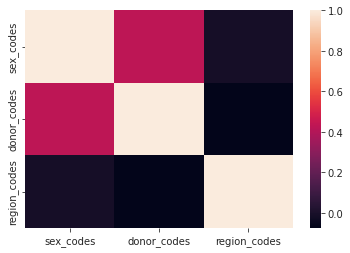

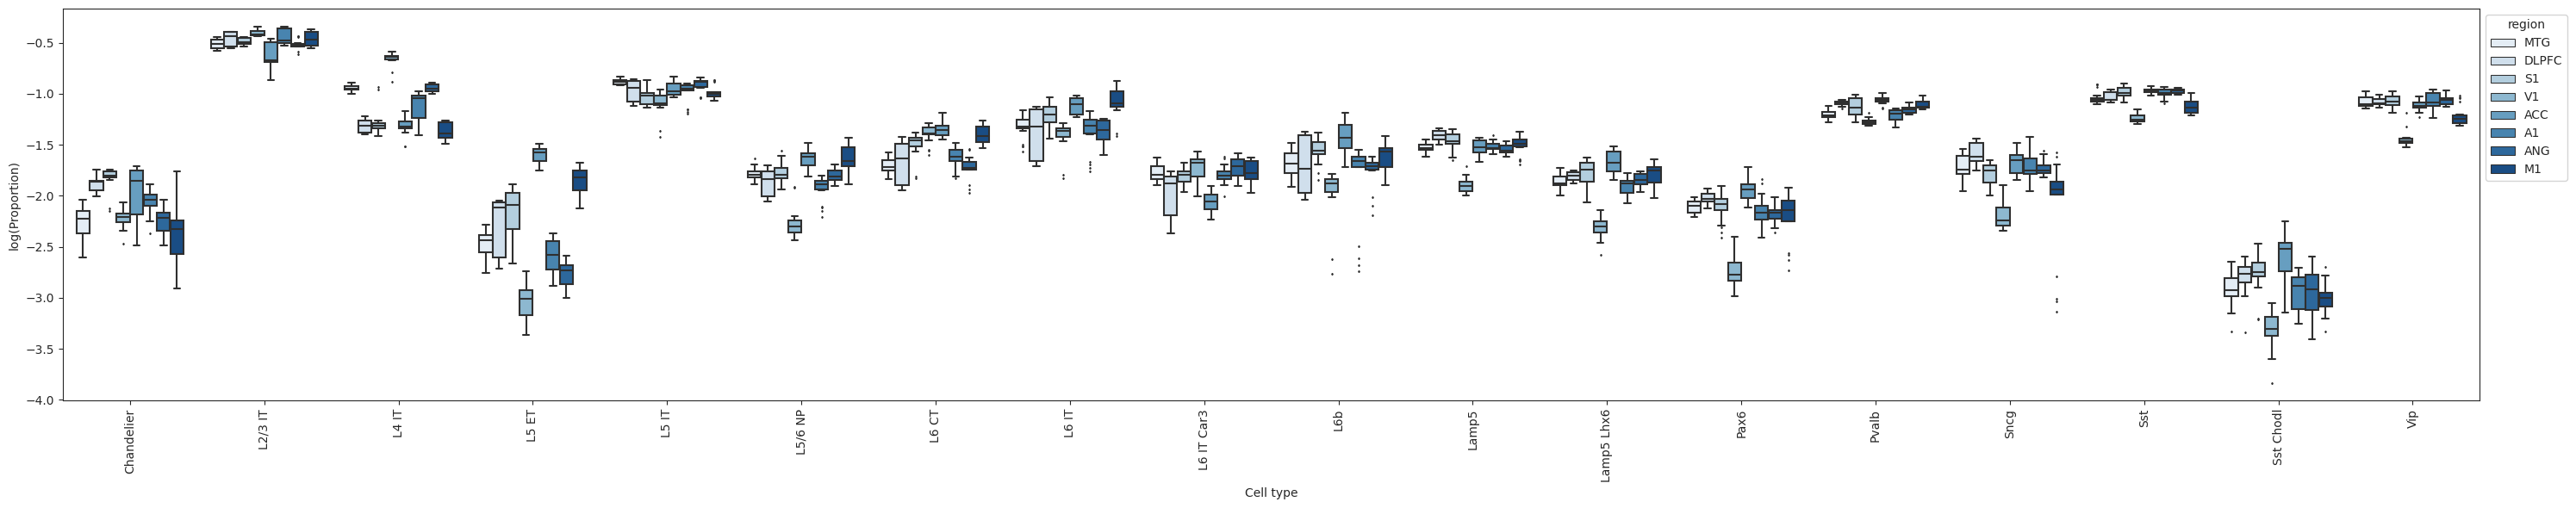

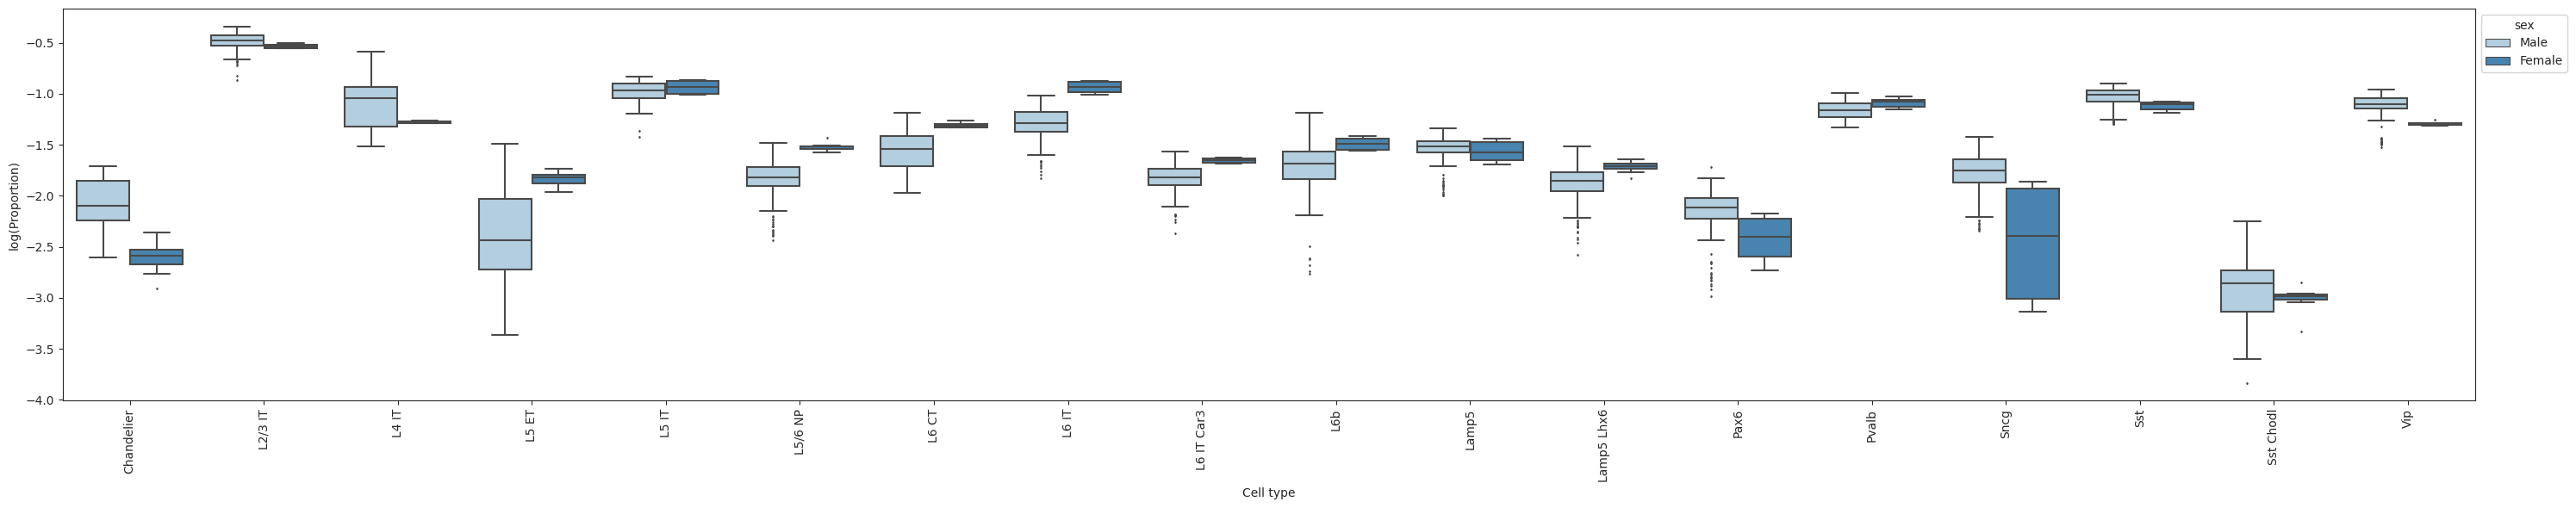

2022-07-13 19:17:37.536929 -- testing across region
Reference region: A1
Reference cell type: Chandelier
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!
Reference cell type: L6 IT Car3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!
Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!
Reference region: ACC
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!
Reference region: ANG
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT
Converged!
Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!
Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!
Reference region: DLPFC
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!
Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!
Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: M1
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!
Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!
Reference region: MTG
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!
Reference cell type: Lamp5 Lhx6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg
Converged!
Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip
Converged!
Reference region: S1
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!
Reference cell type: L6 IT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3
Converged!
Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!
Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!
Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!
Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!
Reference region: V1
Reference cell type: Chandelier
Converged!
Reference cell type: L2/3 IT
Converged!
Reference cell type: L4 IT
Converged!
Reference cell type: L5 ET
Converged!
Reference cell type: L5 IT
Converged!
Reference cell type: L5/6 NP
Converged!
Reference cell type: L6 CT
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT
Converged!
Reference cell type: L6 IT Car3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b
Converged!
Reference cell type: Lamp5
Converged!
Reference cell type: Lamp5 Lhx6
Converged!
Reference cell type: Pax6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb
Converged!
Reference cell type: Sncg
Converged!
Reference cell type: Sst
Converged!
Reference cell type: Sst Chodl
Converged!
Reference cell type: Vip
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


2022-07-13 19:24:04.973132 -- Starting labels_keys=cross_area_cluster
No covariate information specified!


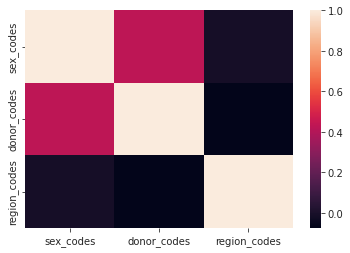

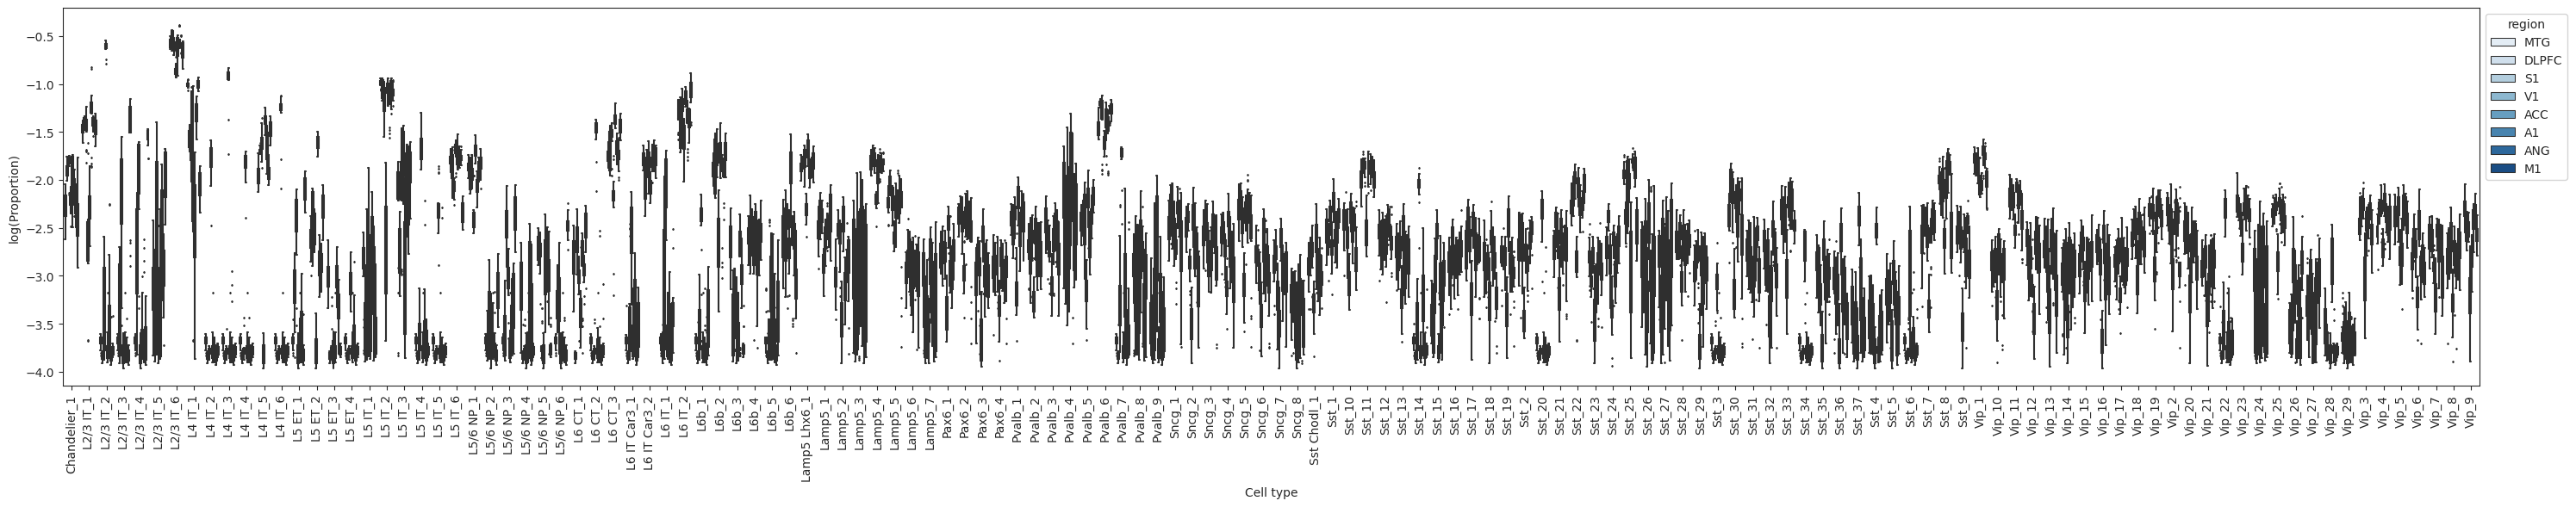

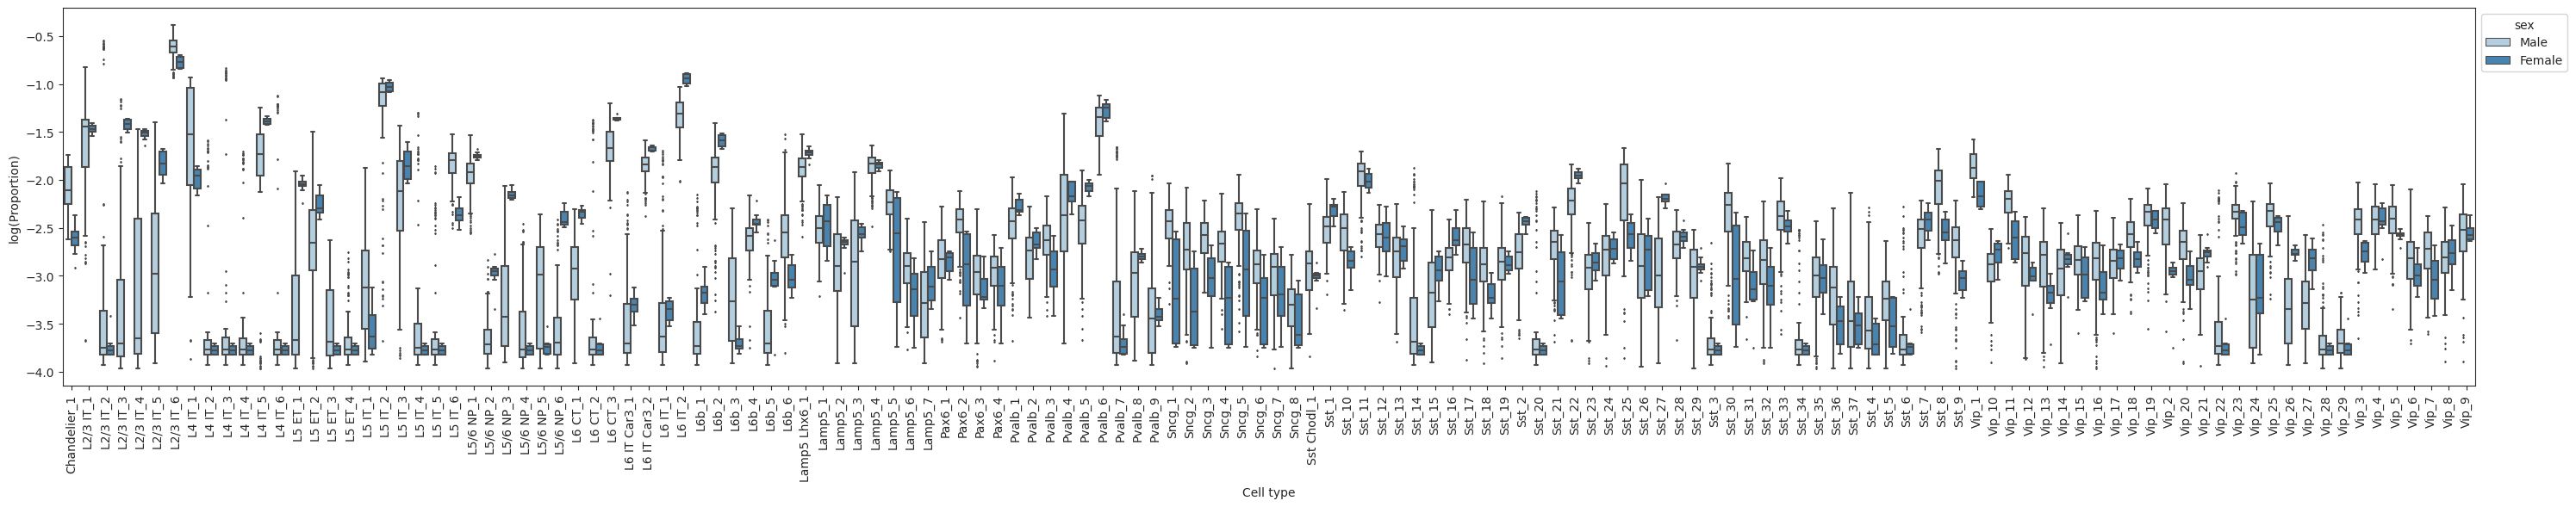

2022-07-13 19:24:24.828296 -- testing across region
Reference region: A1
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_2
Converged!
Reference cell type: L2/3 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_4
Converged!
Reference cell type: L2/3 IT_5
Converged!
Reference cell type: L2/3 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!
Reference cell type: L4 IT_5
Converged!
Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_2
Converged!
Reference cell type: L5 ET_3
Converged!
Reference cell type: L5 ET_4
Converged!
Reference cell type: L5 IT_1
Converged!
Reference cell type: L5 IT_2
Converged!
Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!
Reference cell type: L5/6 NP_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!
Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_1
Converged!
Reference cell type: L6b_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!
Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!
Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!
Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!
Reference cell type: Pax6_4
Converged!
Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!
Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!
Reference cell type: Sst_10
Converged!
Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!
Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!
Reference cell type: Sst_18
Converged!
Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!
Reference cell type: Sst_20
Converged!
Reference cell type: Sst_21
Converged!
Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!
Reference cell type: Sst_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!
Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!
Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!
Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!
Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: ACC
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_4
Converged!
Reference cell type: L2/3 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_6
Converged!
Reference cell type: L4 IT_1
Converged!
Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_2
Converged!
Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!
Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!
Reference cell type: L6 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!
Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!
Reference cell type: Lamp5_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!
Reference cell type: Pax6_1
Converged!
Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_7
Converged!
Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!
Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!
Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!
Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!
Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!
Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_20
Converged!
Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!
Reference cell type: Sst_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!
Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!
Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!
Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!
Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!
Reference cell type: Vip_8
Converged!
Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: ANG
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!
Reference cell type: L2/3 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!
Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!
Reference cell type: L5 ET_2
Converged!
Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!
Reference cell type: L5 IT_5
Converged!
Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!
Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!
Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!
Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!
Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!
Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!
Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!
Reference cell type: Pax6_4
Converged!
Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!
Reference cell type: Pvalb_3
Converged!
Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_7
Converged!
Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!
Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!
Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!
Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_13
Converged!
Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_20
Converged!
Reference cell type: Sst_21
Converged!
Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!
Reference cell type: Sst_25
Converged!
Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!
Reference cell type: Sst_3
Converged!
Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!
Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!
Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!
Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!
Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!
Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_29
Converged!
Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!
Reference region: DLPFC
Reference cell type: Chandelier_1
Converged!
Reference cell type: L2/3 IT_1
Converged!
Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!
Reference cell type: L2/3 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_5
Converged!
Reference cell type: L2/3 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!
Reference cell type: L5 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_3
Converged!
Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!
Reference cell type: L5/6 NP_1
Converged!
Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!
Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!
Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_3
Converged!
Reference cell type: L6b_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!
Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!
Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!
Reference cell type: Pvalb_3
Converged!
Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!
Reference cell type: Pvalb_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_8
Converged!
Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!
Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!
Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!
Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!
Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!
Reference cell type: Sst_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!
Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!
Reference cell type: Sst_3
Converged!
Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!
Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!
Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!
Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!
Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!
Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!
Reference cell type: Vip_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!
Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!
Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!
Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!
Reference cell type: Vip_29
Converged!
Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!
Reference cell type: Vip_8
Converged!
Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: M1
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!
Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_4
Converged!
Reference cell type: L2/3 IT_5
Converged!
Reference cell type: L2/3 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!
Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!
Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!
Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!
Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!
Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!
Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!
Reference cell type: Pvalb_7
Converged!
Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!
Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!
Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!
Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!
Reference cell type: Vip_14
Converged!
Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!
Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!
Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!
Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: MTG
Reference cell type: Chandelier_1
Converged!
Reference cell type: L2/3 IT_1
Converged!
Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!
Reference cell type: L2/3 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_6
Converged!
Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!
Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!
Reference cell type: L5 ET_2
Converged!
Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_3
Converged!
Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!
Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!
Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!
Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!
Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!
Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!
Reference cell type: Pvalb_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!
Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!
Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!
Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!
Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!
Reference cell type: Sst_20
Converged!
Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!
Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!
Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!
Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!
Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!
Reference cell type: Vip_26
Converged!
Reference cell type: Vip_27
Converged!
Reference cell type: Vip_28
Converged!
Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!
Reference cell type: Vip_7
Converged!
Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference region: S1
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_1
Converged!
Reference cell type: L4 IT_2
Converged!
Reference cell type: L4 IT_3
Converged!
Reference cell type: L4 IT_4
Converged!
Reference cell type: L4 IT_5
Converged!
Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!
Reference cell type: L5 ET_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!
Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!
Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!
Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!
Reference cell type: L6 IT_2
Converged!
Reference cell type: L6b_1
Converged!
Reference cell type: L6b_2
Converged!
Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!
Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_2
Converged!
Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!
Reference cell type: Pvalb_4
Converged!
Reference cell type: Pvalb_5
Converged!
Reference cell type: Pvalb_6
Converged!
Reference cell type: Pvalb_7
Converged!
Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!
Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!
Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!
Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!
Reference cell type: Sst_13
Converged!
Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!
Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!
Reference cell type: Sst_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_20
Converged!
Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!
Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!
Reference cell type: Sst_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!
Reference cell type: Sst_33
Converged!
Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!
Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!
Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!
Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!
Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!
Reference cell type: Vip_7
Converged!
Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!
Reference region: V1
Reference cell type: Chandelier_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L2/3 IT_6
Converged!
Reference cell type: L4 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L4 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 ET_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5 IT_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L5/6 NP_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 CT_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT Car3_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6 IT_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_2
Converged!
Reference cell type: L6b_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: L6b_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5 Lhx6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Lamp5_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pax6_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Pvalb_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sncg_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst Chodl_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_28
Converged!
Reference cell type: Sst_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_30
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_31
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_32
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_33
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_34
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_35
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_36
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_37
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Sst_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_1
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_10
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_11
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_12
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_13
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_14
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_15
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_16
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_17
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_18
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_19
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_2
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_20
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_21
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_22
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_23
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_24
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_25
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_26
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_27
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_28
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_29
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_3
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_4
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_5
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_6
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_7
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_8
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Reference cell type: Vip_9
Converged!


/allen/programs/celltypes/workgroups/hct/ktrav/conda/envs/sc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [10]:
region = "cross_areal"
formula = "sex + "
covariates = ["library_prep", "sex", "donor", "region"]
tests = ["region"]
labels_keys=["class", "cross_area_subclass", "cross_area_cluster"]
run_scCODA(
    cell_count=cell_count,
    random_effect="library_prep",
    split_key="class",
    split_value=["excitatory", "inhibitory"],
    labels_keys=labels_keys,
    region=region,
    covariates=covariates,
    tests=tests,
    formula=formula,
    figsize=(30,6)
)

/scratch/fast/6427930/ipykernel_299333/1603249711.py:32: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
/scratch/fast/6427930/ipykernel_299333/1603249711.py:38: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  results_table["Covariate"].cat.remove_unused_categories(inplace=True)


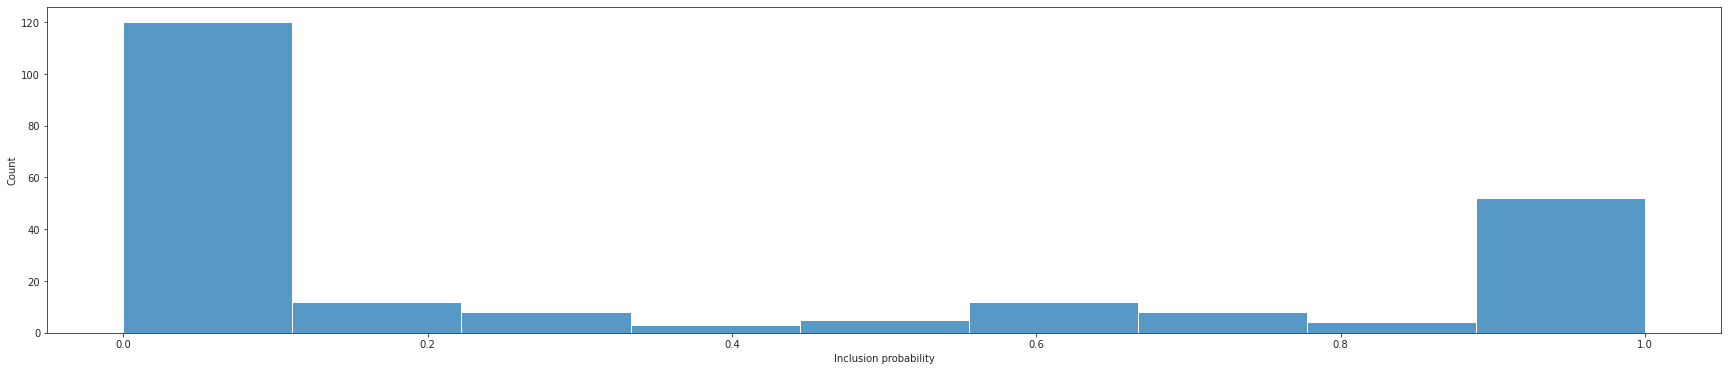

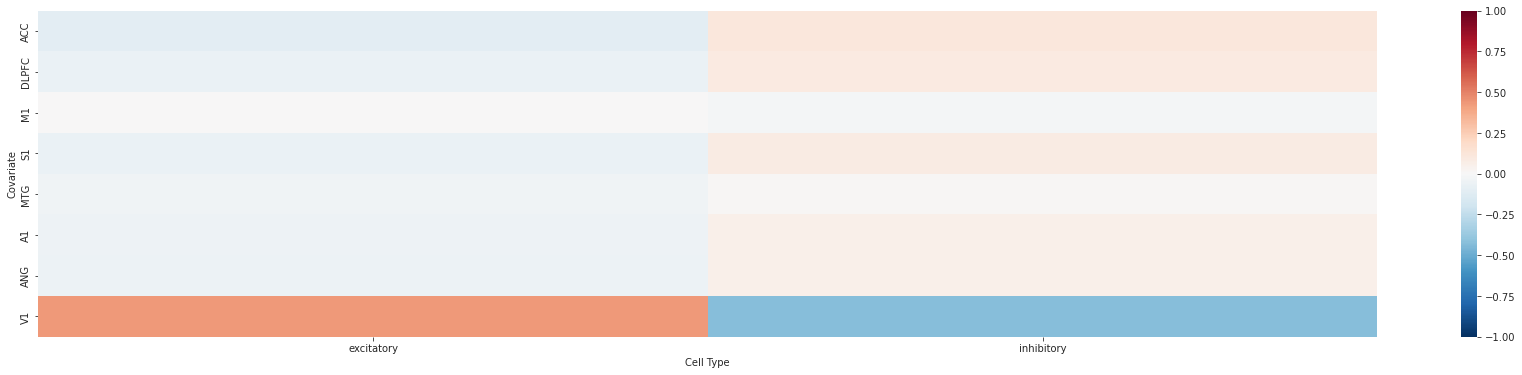

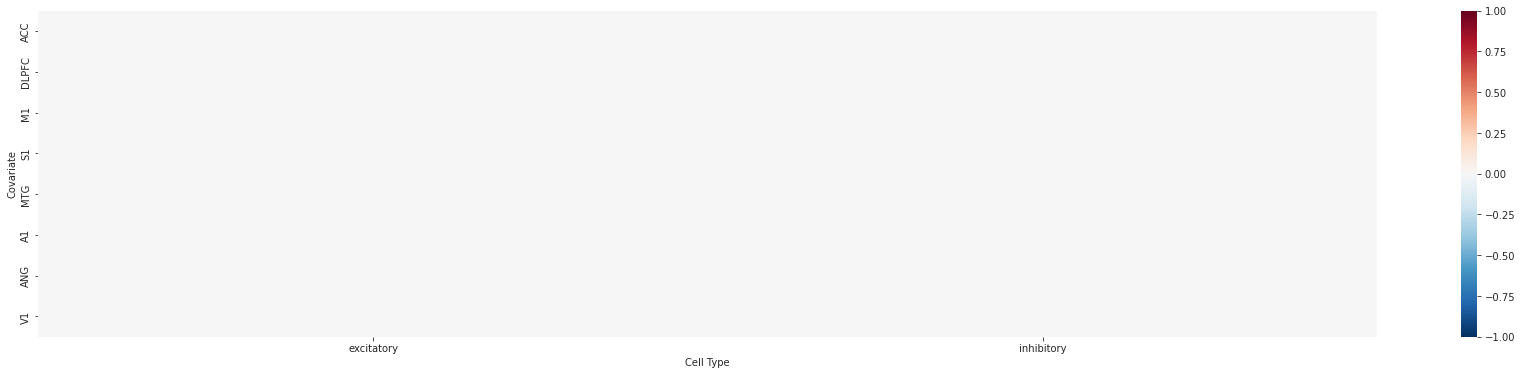

/scratch/fast/6427930/ipykernel_299333/1603249711.py:32: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
/scratch/fast/6427930/ipykernel_299333/1603249711.py:38: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  results_table["Covariate"].cat.remove_unused_categories(inplace=True)


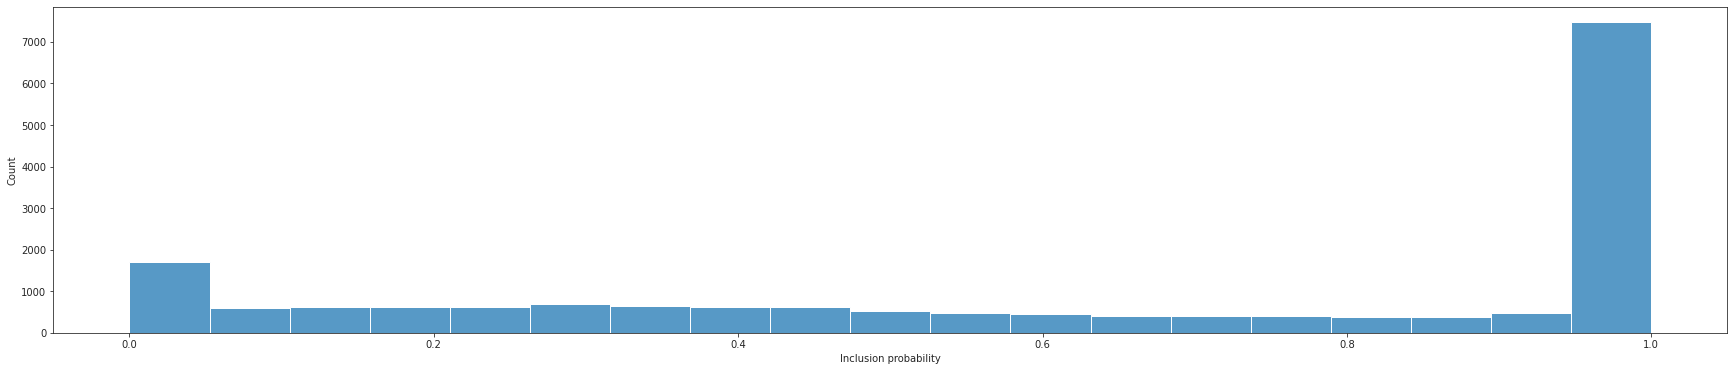

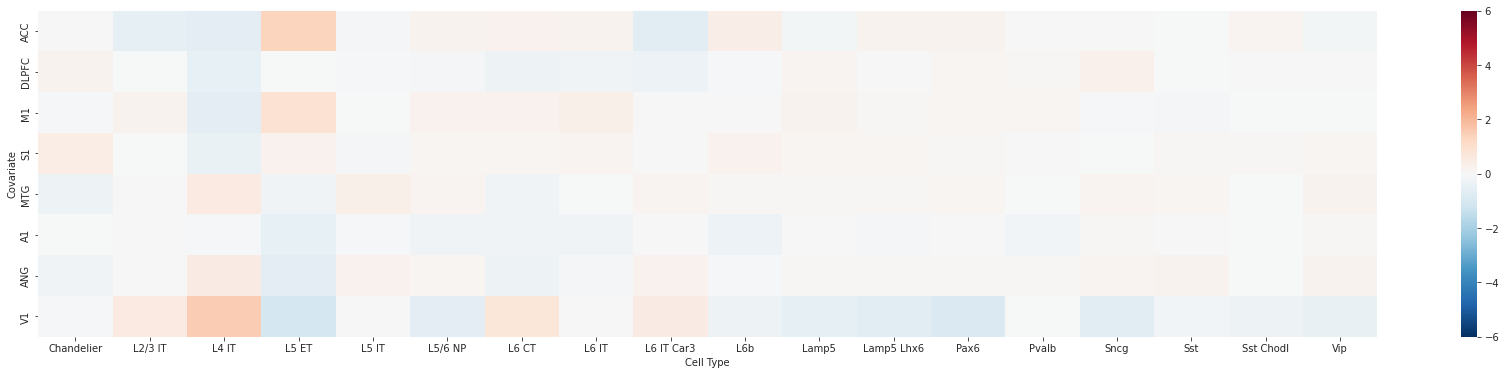

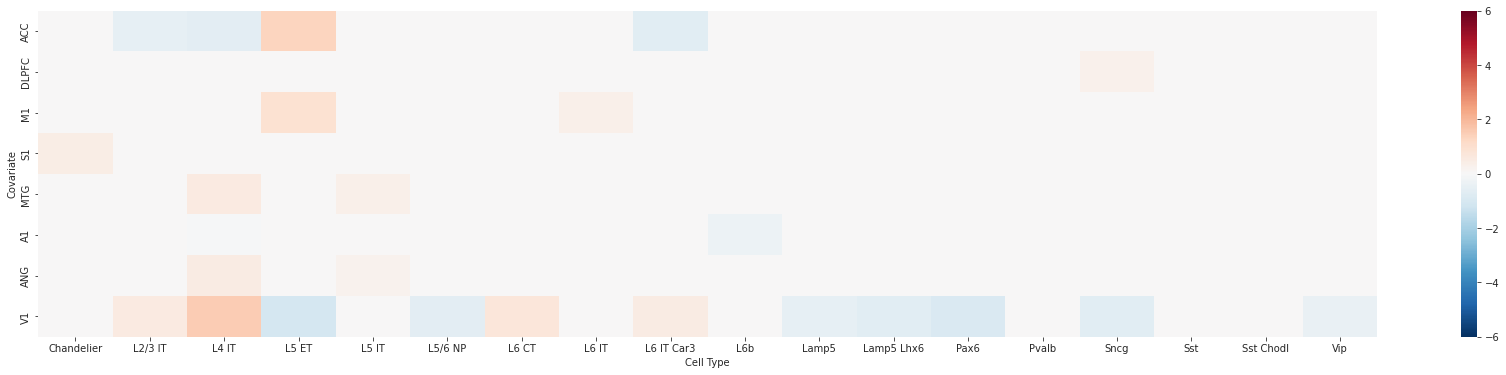

/scratch/fast/6427930/ipykernel_299333/1603249711.py:26: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Cell Type"].cat.reorder_categories(plot_order[k], inplace=True)
/scratch/fast/6427930/ipykernel_299333/1603249711.py:32: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
/scratch/fast/6427930/ipykernel_299333/1603249711.py:38: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  results_table["Covariate"].cat.remove_unused_categories(inplace=True)


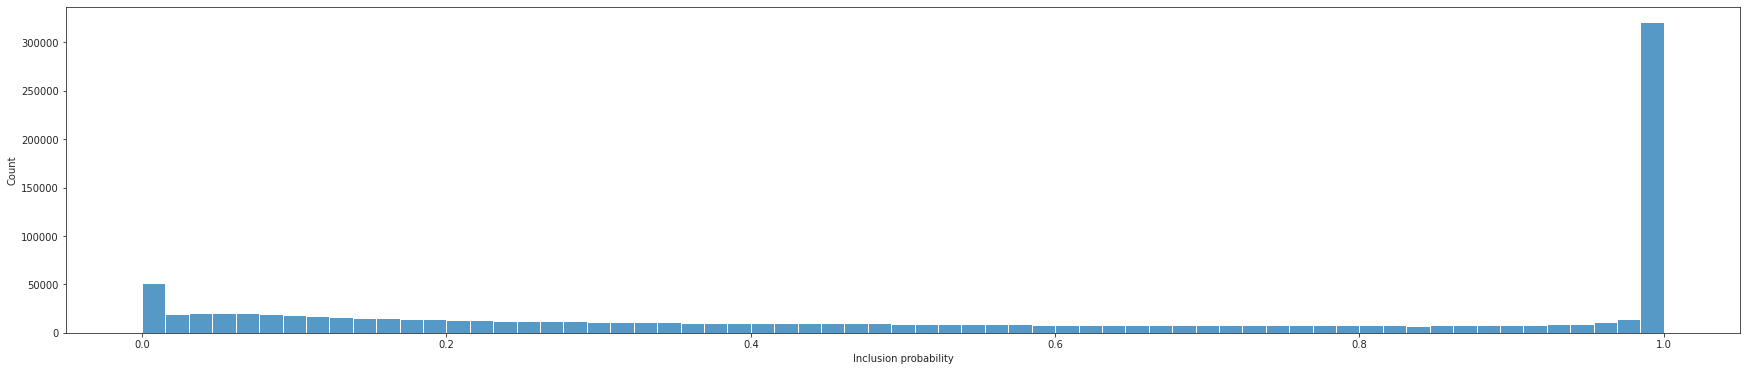

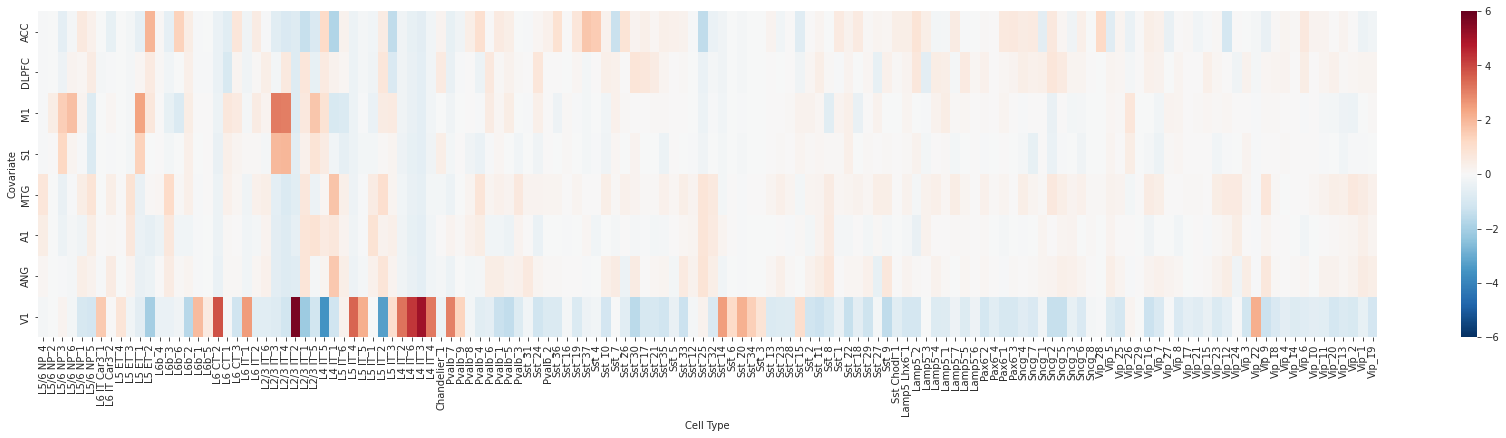

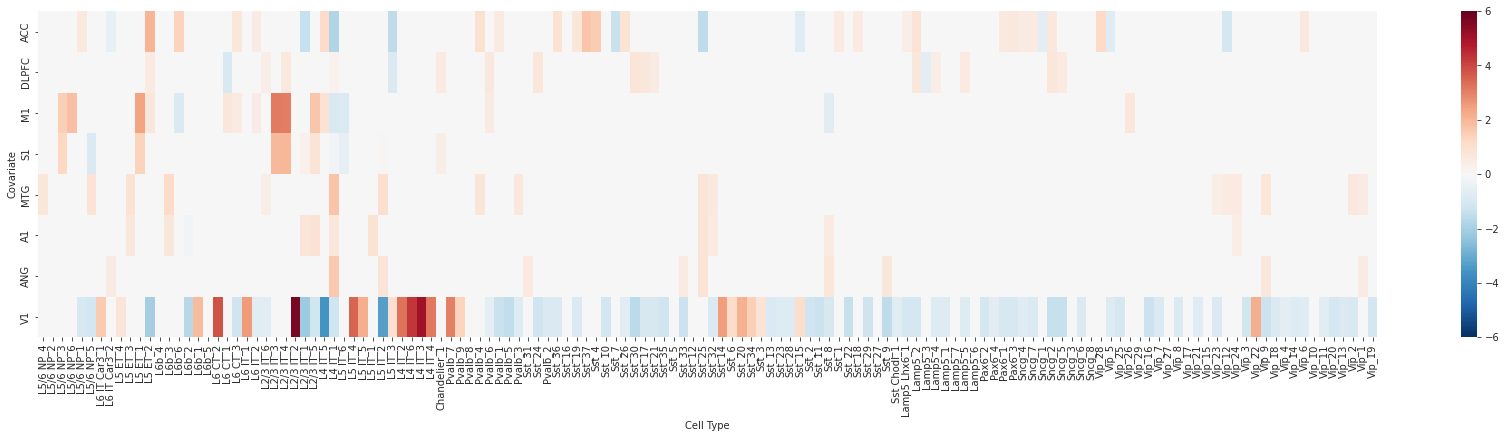

In [66]:
plt.rcParams['figure.figsize'] = (30,6)
plot_size = {"class": [-1, 1], "cross_area_subclass": [-6, 6], "cross_area_cluster": [-6, 6]}
dend_order = pd.read_csv("dend_order_neurons.csv", header=None)
plot_order = {"cross_area_cluster": dend_order.iloc[:, 0].to_list()}

plot_colors = {}
covariate_order = ["ACC", "DLPFC", "M1", "S1", "MTG", "A1", "ANG", "V1", "sex[T.Male]"]
drop_covariates = ["sex[T.Male]"]

for j in tests:
    for k in labels_keys:
        results_tables = glob.glob(os.path.join("output", region, j, "**", "excitatory inhibitory_" + k + "_results.csv"))
        results_table = False
        for z in results_tables:
            tmp = pd.read_csv(z, index_col=0)
            tmp["Covariate"] = [re.sub("C\([^,]+, Treatment\('[^\)]+'\)\)\[T.([^\]]+)\]$", "\\1", y) for y in tmp["Covariate"]]
            try:
                results_table = pd.concat([results_table, tmp], axis=0)
            except:
                results_table = tmp.copy()
        
        results_table["Credible"] = results_table["Final Parameter"] != 0
        
        try:
            results_table["Cell Type"] = results_table["Cell Type"].astype("category")
            results_table["Cell Type"].cat.reorder_categories(plot_order[k], inplace=True) 
        except:
            pass
        
        try:
            results_table["Covariate"] = results_table["Covariate"].astype("category")
            results_table["Covariate"].cat.reorder_categories(covariate_order, inplace=True)
        except:
            pass
        
        try:
            results_table = results_table.loc[[l not in drop_covariates for l in results_table["Covariate"]], :]
            results_table["Covariate"].cat.remove_unused_categories(inplace=True)
        except:
            pass
        
        sns.histplot(results_table["Inclusion probability"]);
        plt.show();
        
        tmp = results_table.loc[:, ["Covariate", "Cell Type", "Final Parameter"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.columns = ["Covariate", "Cell Type", "Effect Size"]
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0,
            cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );
        plt.savefig(os.path.join(pwd, "output", "figures", "neurons_" + j + "_" + k + "_effect_size_unfiltered.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "neurons_" + j + "_" + k + "_effect_size_unfiltered.csv"))
        
        tmp2 = results_table.loc[:, ["Covariate", "Cell Type", "Inclusion probability"]].groupby(["Covariate", "Cell Type"]).mean().reset_index()
        tmp.loc[tmp2["Inclusion probability"] < 0.8, "Effect Size"] = 0
        ax = sns.heatmap(
            tmp.pivot(index="Covariate", columns="Cell Type", values="Effect Size"),
            center=0, cmap="RdBu_r",
            vmin=plot_size[k][0],
            vmax=plot_size[k][1],
            xticklabels=True
        );
        plt.savefig(os.path.join(pwd, "output", "figures", "neurons_" + j + "_" + k + "_effect_size_p_gt_0.8.pdf"), bbox_inches="tight")
        plt.show();
        tmp.to_csv(os.path.join(pwd, "output", "figures", "neurons_" + j + "_" + k + "_effect_size_p_gt_0.8.csv"))
            
plt.rcParams['figure.figsize'] = (6,4)